In [44]:
rm(list=ls())
library('Biobase')
library('limma')
library("biomaRt")
library("edgeR")
library('gplots')
library('EnhancedVolcano')
library("clusterProfiler")
library("DOSE")
library("tibble")
library("org.Hs.eg.db")
library("enrichplot")
library("GOSemSim")
library("GOplot")
library(data.table)
library("AnnotationDbi")
library(pathview)
library(gage)
library(gageData)

PATH = paste(getwd(), sep = .Platform$file.sep)
PATH_DATA = paste(PATH, 'Data', sep = .Platform$file.sep)
PAPER_DATA = paste(PATH, 'Supplementary', sep = .Platform$file.sep)

In [45]:
packageVersion('limma')
packageVersion('clusterProfiler')
packageVersion('org.Hs.eg.db')
packageVersion("enrichplot")

[1] ‘3.50.3’

[1] ‘4.2.2’

[1] ‘3.14.0’

[1] ‘1.14.2’

#### Load gene annotations

In [46]:
annot <- read.csv(file = paste(PATH_DATA, 'Annotations.tsv', sep = .Platform$file.sep) , sep = '\t', header = TRUE)

annot <- annot[!duplicated(annot$ensembl_gene_id), ]
rownames(annot) <- annot$ensembl_gene_id

head(annot)
dim(annot)

,ensembl_gene_id,entrezgene_id,hgnc_symbol,chromosome_name,strand,start_position,end_position,gene_biotype
,<chr>,<int>,<chr>,<chr>,<int>,<int>,<int>,<chr>
ENSG00000210049,ENSG00000210049,NA,MT-TF,MT,1,577,647,Mt_tRNA
ENSG00000211459,ENSG00000211459,NA,MT-RNR1,MT,1,648,1601,Mt_rRNA
ENSG00000210077,ENSG00000210077,NA,MT-TV,MT,1,1602,1670,Mt_tRNA
ENSG00000210082,ENSG00000210082,NA,MT-RNR2,MT,1,1671,3229,Mt_rRNA
ENSG00000209082,ENSG00000209082,NA,MT-TL1,MT,1,3230,3304,Mt_tRNA
ENSG00000198888,ENSG00000198888,4535,MT-ND1,MT,1,3307,4262,protein_coding


[1] 68016     8

#### Load meta data

In [47]:
meta <- read.delim( paste(PATH_DATA, "meta_subset.tsv", sep = .Platform$file.sep) , row.names=1)
head(meta)
dim(meta)

,basevitdng,wk32to38vitdng,mayocbloodvitd,condition,deliverydate,site,bdeath,trmt,cgender,cethnicity,crace,craceeth,clusters
,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
114469,52.2,47.3,34,High,01/17/2011,1,No,A,Male,Not_Hispanic_or_Latino,Asian,Other,0
125208,33.3,66.8,26,High,11/22/2010,1,No,A,Male,Hispanic_or_Latino,Asian,Other,0
129302,48.8,59.8,48,High,11/17/2011,1,No,A,Male,Not_Hispanic_or_Latino,Asian,Other,0
133333,28.9,44.1,30,High,01/29/2011,1,No,A,Male,Hispanic_or_Latino,Other,Other,0
142292,32.6,35.6,29,High,10/28/2010,1,No,B,Female,Not_Hispanic_or_Latino,White,CaucasianNonHispanic,0
147980,35.1,39.6,41,High,02/17/2011,1,No,A,Female,Not_Hispanic_or_Latino,White,CaucasianNonHispanic,0


[1] 97 13

#### Load counts data

In [48]:
## Load expression data
counts <- read.delim(paste(PATH_DATA, 'gene_counts.tsv', sep = .Platform$file.sep), row.names = 1)
colnames(counts) <- gsub("X","",colnames(counts))
tail(counts)
dim(counts)


,110188,111485,111733,112434,113223,113321,113402,114430,114469,114718,⋯,394540,394765,394806,394913,395879,396641,398087,399652,399773,399891
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000282817,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000282818,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000282819,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000282820,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000282821,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000282822,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


[1] 65988   443

In [49]:
counts <- counts[, rownames(meta)]
genes <- intersect(rownames(counts), rownames(annot))
annot <- annot[genes,]
counts <- counts[genes,]

dim(counts)
dim(meta)
dim(annot)

[1] 61553    97

[1] 97 13

[1] 61553     8

In [50]:
samples <- colnames(counts)
nsamples <- length(samples)

### <u> <font color=blue> Normalize counts data </font>  </u>

In [51]:
x <- DGEList(counts)
dim(x)

[1] 61553    97

In [52]:
## Store meta information in x
x$genes <- annot
samplenames <- rownames(meta)
group <- meta$condition
x$samples$group <- meta$condition


In [53]:
## Convert counts to cpm and log-cpm
cpm <- cpm(x)
lcpm <- cpm(x, log=TRUE)

L <- mean(x$samples$lib.size) * 1e-6
M <- median(x$samples$lib.size) * 1e-6
c(L, M)


[1] 4.573374 4.318878

In [54]:
## Removing genes with lowly expressed genes
table(rowSums(x$counts==0)==nsamples)


FALSE  TRUE 
47746 13807 

In [55]:
## Larger the library size, lower the CPM cutoff and vice versa
keep.exprs <- filterByExpr(x, group=group, min.count = 12)
x <- x[keep.exprs,, keep.lib.sizes=FALSE]
dim(x)

[1] 12490    97

Warning message in brewer.pal(nsamples, "Paired"):
“n too large, allowed maximum for palette Paired is 12
Returning the palette you asked for with that many colors
”


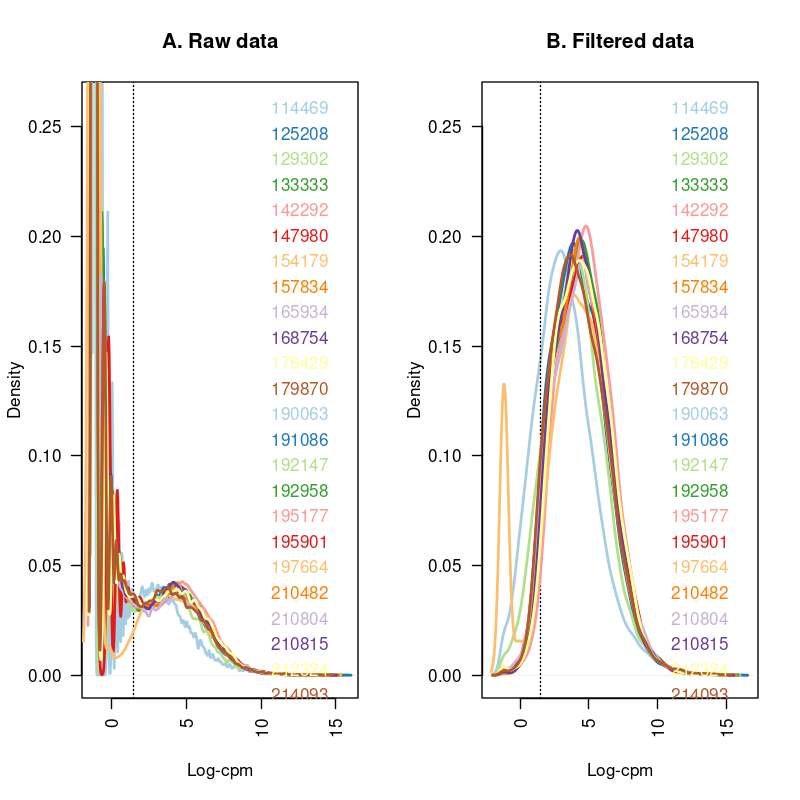

In [56]:
lcpm.cutoff <- log2(10/M + 2/L)
library(RColorBrewer)
nsamples <- ncol(x)
col <- brewer.pal(nsamples, "Paired")
par(mfrow=c(1,2))
plot(density(lcpm[,1]), col=col[1], lwd=2, ylim=c(0,0.26), las=2, main="", xlab="")
title(main="A. Raw data", xlab="Log-cpm")
abline(v=lcpm.cutoff, lty=3)

for (i in 2:nsamples){
 den <- density(lcpm[,i])
 lines(den$x, den$y, col=col[i], lwd=2)
}


legend("topright", samplenames, text.col=col, bty="n")
lcpm <- cpm(x, log=TRUE)
plot(density(lcpm[,1]), col=col[1], lwd=2, ylim=c(0,0.26), las=2, main="", xlab="")
title(main="B. Filtered data", xlab="Log-cpm")
abline(v=lcpm.cutoff, lty=3)

for (i in 2:nsamples){
 den <- density(lcpm[,i])
 lines(den$x, den$y, col=col[i], lwd=2)
}

legend("topright", samplenames, text.col=col, bty="n")

In [57]:
## Normalisation is required to ensure that the expression distributions
## of each sample are similar across the entire experiment.
x <- calcNormFactors(x, method = "TMM")
# x$samples$norm.factors

In [58]:
x2 <- x
x2$samples$norm.factors <- 1
x2$counts[,1] <- ceiling(x2$counts[,1]*0.05)
x2$counts[,2] <- x2$counts[,2]*5

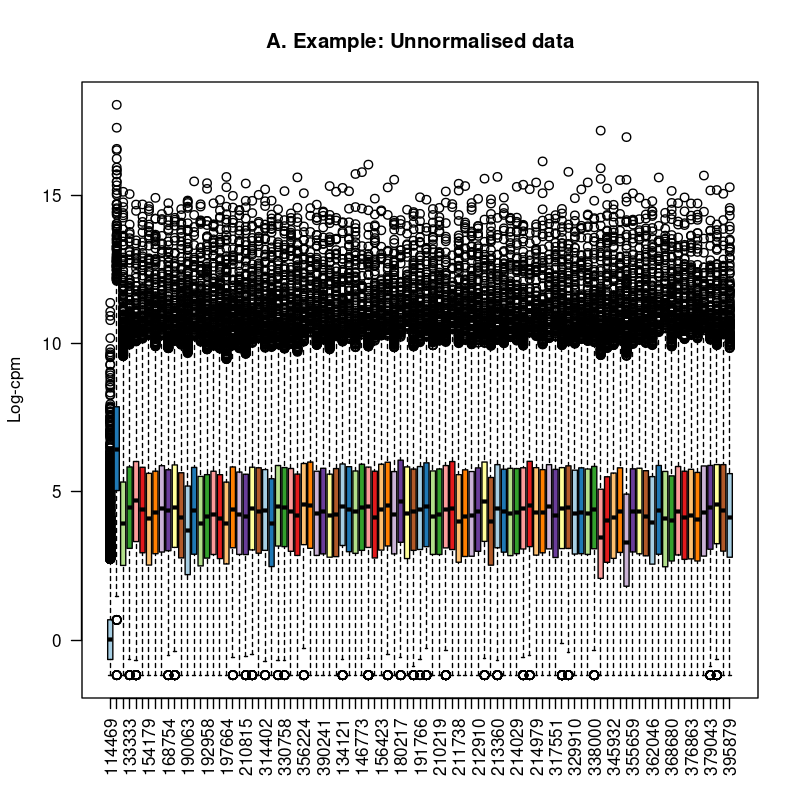

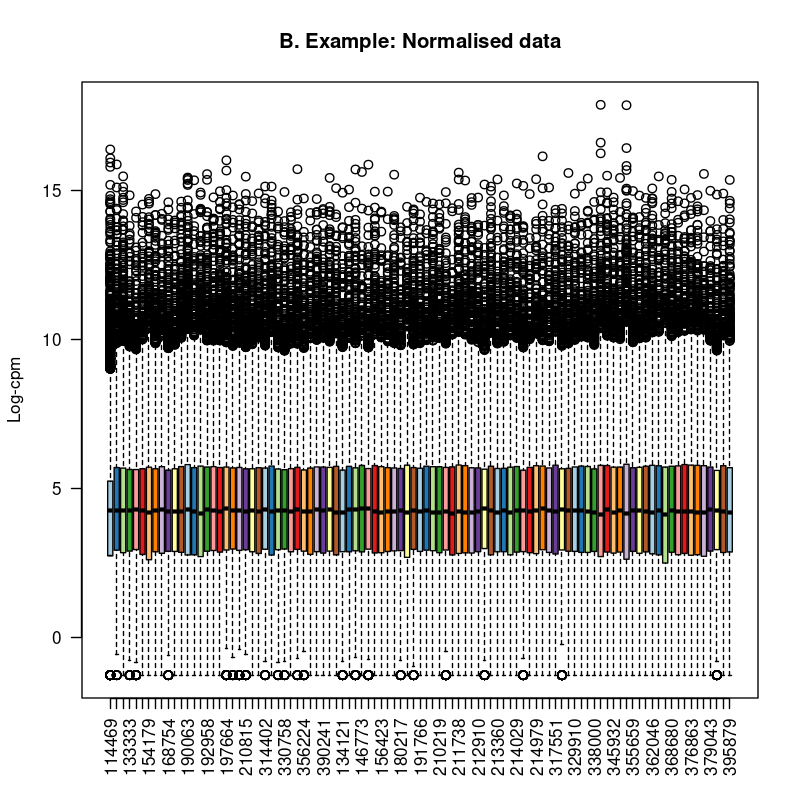

In [59]:
#par(mfrow=c(1,2))
lcpm <- cpm(x2, log=TRUE)
boxplot(lcpm, las=2, col=col, main="")
title(main="A. Example: Unnormalised data", ylab="Log-cpm")
x2 <- calcNormFactors(x2)
# x2$samples$norm.factors
lcpm <- cpm(x2, log=TRUE)
boxplot(lcpm, las=2, col=col, main="")
title(main="B. Example: Normalised data", ylab="Log-cpm")

In [60]:
dim(lcpm)

[1] 12490    97

This shows that samples are best separated on the first dimension based on the biological condition of exposure
to Vitamin D and differentially expressed genes are expected to arise from this condition.

## DE analysis

In [61]:
# Create design matrix for study
design <- model.matrix(~0 + condition + site + crace + cethnicity, data = meta)  

# Count the number of samples modeled by each coefficient
colSums(design)

head(design)

conditionHigh                     conditionLow 
                              35                               62 
                            site                       craceAsian 
                             200                                8 
    craceBlack__African_American                       craceOther 
                              52                                8 
                      craceWhite cethnicityNot_Hispanic_or_Latino 
                              27                               68

,conditionHigh,conditionLow,site,craceAsian,craceBlack__African_American,craceOther,craceWhite,cethnicityNot_Hispanic_or_Latino
114469,1,0,1,1,0,0,0,1
125208,1,0,1,1,0,0,0,0
129302,1,0,1,1,0,0,0,1
133333,1,0,1,0,0,1,0,0
142292,1,0,1,0,0,0,1,1
147980,1,0,1,0,0,0,1,1


In [62]:
cm <- makeContrasts(Vit.D.HighvsVit.D.Low = conditionHigh - conditionLow,
                   levels = design)

cm

,Vit.D.HighvsVit.D.Low
conditionHigh,1
conditionLow,-1
site,0
craceAsian,0
craceBlack__African_American,0
craceOther,0
craceWhite,0
cethnicityNot_Hispanic_or_Latino,0


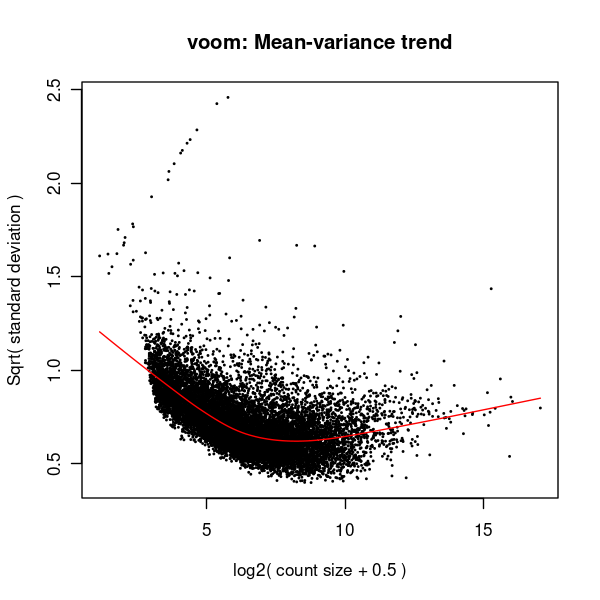

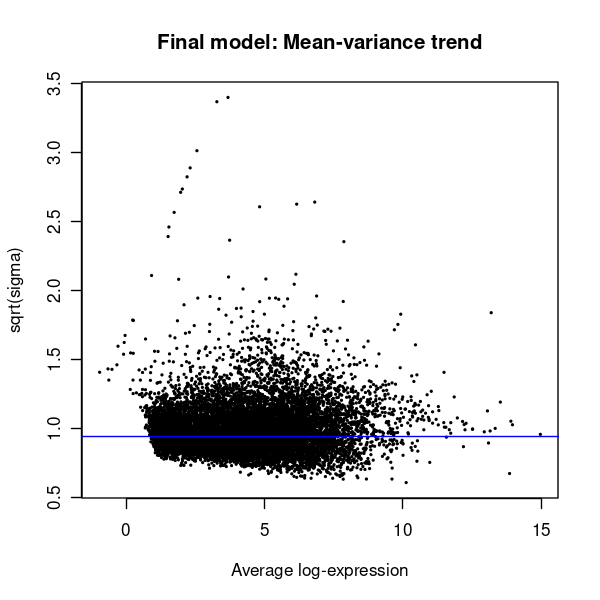

In [63]:
options(repr.plot.width = 6, repr.plot.height = 6)
v <- voom(x, design, plot=TRUE) 

# Fit the model
fit <- lmFit(v, design)

# Fit the contrasts
fit2 <- contrasts.fit(fit, contrasts = cm)

# Calculate the t-statistics for the contrasts
fit2 <- eBayes(fit2)
plotSA(fit2, main="Final model: Mean-variance trend")


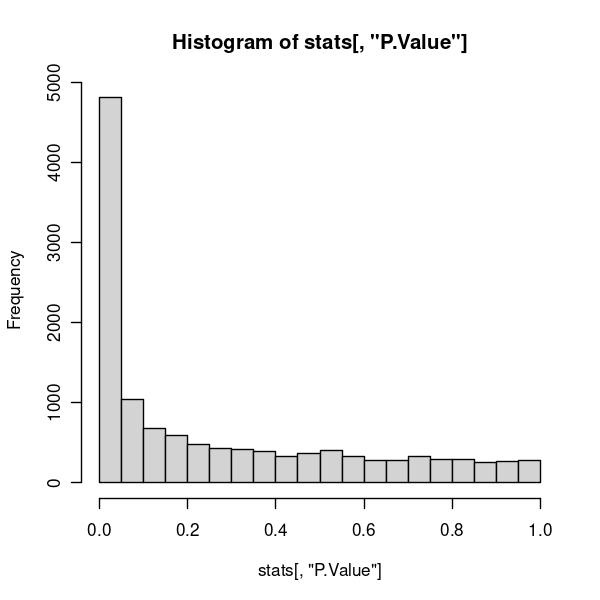

In [64]:
# Obtain the summary statistics for every gene
stats <- topTable(fit2, number = nrow(fit2), sort.by = "none")

# Plot a histogram of the p-values
hist(stats[, "P.Value"])

In [65]:
# Summarize results
results <- decideTests(fit2, p.value = 0.05)
summary(results)

       Vit.D.HighvsVit.D.Low
Down                    2026
NotSig                  9114
Up                      1350

In [66]:
log2(1.25)

[1] 0.3219281

In [67]:
res <- topTable(fit2, coef='Vit.D.HighvsVit.D.Low', number=Inf, sort.by='p', lfc = 0.585, p.value = 0.05)

down_genes = summary(results)['Down','Vit.D.HighvsVit.D.Low']
up_genes = summary(results)['Up','Vit.D.HighvsVit.D.Low']

## Differentially expressed genes
de_genes <- head(res, up_genes+down_genes)

fcvals_up <- de_genes[de_genes['logFC'] > 0,]
fcvals_down <- de_genes[de_genes['logFC'] < 0,]
dim(fcvals_up)
dim(fcvals_down)

[1] 145  14

[1] 594  14

In [68]:
write.csv(fcvals_up,'Supplementary/fcvals_up_vdaart_high.csv')
write.csv(fcvals_down,'Supplementary/fcvals_down_vdaart_low.csv')


In [69]:
'VDR' %in% annot[rownames(fcvals_up) ,]$hgnc_symbol
'VDR' %in% annot[rownames(fcvals_down),]$hgnc_symbol

[1] FALSE

[1] TRUE

In [70]:
cat(sort(c(annot[rownames(fcvals_up) ,]$hgnc_symbol)))

         ABCB5 ABCC13 ACSL6 AK5 AKAP7 AKR1E2 ALAS2 ALS2CL ANKRD36BP2 ARL4A ATP1B2 BMS1P1 BNIP3L BPGM C9orf78 CATSPERB CCDC18 CCNB1 CD2AP CDC25C CDC42BPA CDKN3 CENPH CENPK CEP70 CISD2 CRPPA CYP4A22-AS1 DCAF12 DCUN1D1 DMC1 DNAH14 DNAI4 DNAJC6 DPCD DPY19L1P2 DSC1 E2F2 EFCAB13 ELOVL6 EPB41L4A ERVH48-1 FAM210B FANCL FLACC1 FOXO3 GALNT6 GMPR GOLGA6L9 GYPA GYPB GYPE GZMA HBM HBQ1 HCCS-DT HEBP1 HEMGN HERC2P3 HIGD1A IBA57 IGF2 ISCA1 KHDC1-AS1 KIF14 KIF15 KIF20B LIN9 LINC00920 LINC01781 LINC01891 LINC02615 LRRCC1 LZTFL1 MAN1C1 MBNL3 MICAL2 MKLN1-AS NDUFA5 NEIL3 NEK1 NKD1 NUP62CL PAGE2B PAQR9 PBX1 PLVAP POLE2 PRELID2 PRR4 RANBP17 RGS6 RIOK3 RSAD2 RUNDC3A-AS1 SARDH SBF2-AS1 SCART1 SKA3 SLC14A1 SLC16A1 SLC16A10 SLC7A5 SLFN14 SNPH SPAG16 SPTB SSTR3 TENT5C TEX9 TLCD4 TMEM158 TMOD1 TNS1 TRAJ12 TRAJ14 TRAJ22 TRAJ3 TRAJ5 TRAJ6 TRAK2 TRAV13-1 TRAV8-3 TRAV9-2 TRBV10-3 TRIM58 TSPAN18 UBE2O UBE2Q2P2 UBXN10 USP44 WDR26 WDR31 XK YOD1 ZFAND4

In [71]:
cat(sort(annot[rownames(fcvals_down),]$hgnc_symbol))


                              AATK ABCA13 ACSL1 ACSL4 ACSS3 ADAM9 ADAP2 ADGRG3 ADM AGPAT2 AIM2 ALDH1A1 ALDH2 ALDH3B1 ALG1L13P ALOX5AP ALPL ANKRD18A ANKRD22 ANXA2 ANXA3 ANXA5 AP5B1 APMAP APOBEC3A AQP9 ARHGEF40 ARL11 ARL8A ASGR1 ASGR2 ASPH ATP2C2 AZU1 B3GNT5 B4GALT5 BASP1 BASP1-AS1 BCL2A1 BCL3 BCL6 BEND2 BMX BPI BRI3 BST1 BTNL8 C19orf38 C1orf162 C3AR1 C3orf86 C5AR2 CA4 CACNA1D CACNA1E CACNA2D3 CAMP CAPG CAPNS2 CASP5 CATIP-AS1 CAVIN2 CCDC149 CCR1 CCR2 CD14 CD163 CD177 CD1D CD300C CD300E CD300LB CD300LF CD33 CD63 CD86 CDA CDC42EP2 CDC42EP3 CDH26 CEACAM1 CEACAM6 CEACAM8 CEBPA CEBPB CEBPD CEBPE CFP CGAS CHIT1 CHST15 CKAP4 CLEC10A CLEC12A CLEC12B CLEC1A CLEC1B CLEC4D CLEC4E CLEC5A CLEC6A CLIC1 CLTCL1 CLU CMTM1 CMTM2 CMTM4 CMTM5 COL17A1 CPD CPNE2 CPQ CPVL CREB5 CRISPLD2 CRTAP CSF2RA CSRNP1 CST3 CST7 CSTA CTSH CTSS CTTNBP2NL CXCL16 CXCR1 CXCR2 CYP1B1 CYP1B1-AS1 CYP4F3 CYRIA DAAM2 DAPK2 DDX10P1 DENND10 DENND3-AS1 DGAT2 DHRS7 DHRS9 DOCK4 DOK1 DOK3 DRAM1 DSE DUSP1 DUSP3 DZIP1L ECHDC3 EFEMP2 EMILIN

In [72]:
de_plot_genes <- fcvals_down
cat(as.data.frame(de_plot_genes[grep('^CD', de_plot_genes$hgnc_symbol),])$hgnc_symbol)

CD14 CD63 CD1D CD300LF CDA CD86 CDC42EP3 CD33 CD300E CD300LB CD163 CD177 CDH26 CDC42EP2 CD300C

In [73]:
down_genes <- c(annot[rownames(fcvals_down),]$hgnc_symbol)
up_genes <- c(annot[rownames(fcvals_up) ,]$hgnc_symbol)
vitd_target <- c('VDR', 'VDRE', 
              ## GO
              'CYP2R1','CYP24A1', 'CYP27A1', 'CYP27B1', 'ENPP1', 'FGF23','FGFR1', 'FGFR4','GC','GFI1','IFNG','LRP2','NFKB1','SNAI1','SNAI2','TNF', 
              ## WikiPathways
              'ABCB1', 'ABCA11', 'ABCD1', 'ADAMTS5', 'ADGRE5', 'ADRA1B', 'ADRB2', 'ALOX5', 'ALPG', 'ALPI',
              'ASAP2', 'ATP2B1', 'ATP2C2', 'BCL6', 'BDKRB1', 'BGLAP', 'BMP6', 'BTLA', 'CA9', 'CALB1', 'CAMP',
              'CASP14', 'CASP5', 'CBS', 'CCNC', 'CCND1', 'CCNE1', 'CD14', 'CD200', 'CD40', 'CD9', 'CDC34', 'CDK2',
              'CDKAL1', 'CDKN1A', 'CDKN1B', 'CDKN2A', 'CDKN2B', 'CDKN2C', 'CDKN2D', 'CDX2', 'CEACAM1', 'CEBPA',
              'CLDN2', 'CLEC16A', 'CLMN', 'CLPTM1L', 'COLEC11', 'CRACR2A', 'CRACR2B', 'CREG2', 'CST1', 'CST6', 
              'CTLA4', 'CYP1A1', 'CYP24A1', 'CYP27B1', 'CYP2B6', 'CYP2C9', 'CYP2D6', 'CYP2S1', 'CYP3A4', 'CYP3A5',
              'CYP7A1', 'COL13A1', 'DACT2', 'DEFB109C', 'DEFB132', 'DEFB4A', 'DND1', 'DNER', 'DUSP10', 'EFNA5',
              'EPHB4', 'FGF23', 'FOXO1', 'G0S2', 'G6PD', 'GADD45A', 'GXYLT2', 'HIF1A', 'HILPDA', 'HLA-DQA1', 'HLA-DRB1',
              'HNF1A', 'HSD17B2', 'ID1', 'ID4', 'IGFBP1', 'IGFBP3', 'IGFBP5', 'IGSF9B', 'IL12A', 'IL1RL1', 'IL25', 'IRF4',
              'IRF5', 'IRF8', 'ITGAM', 'JUNB', 'KL', 'KLF4', 'KLK6', 'KNG1', 'KRT13', 'KRT16', 'KRT34', 'KRT38', 'KRT71',
              'KRTAP10-2', 'KRTAP10-4', 'KRTAP10-7', 'KRTAP10-9', 'KRTAP12-2', 'KRTAP4-1', 'KRTAP5-1', 'KRTAP5-4', 'KRTAP8-1',
              'LCE1D', 'LCE1F', 'LCE2B', 'LGALS9', 'LPGAT1', 'LRP5', 'LRRC25', 'LRRC8A', 'Ligand', 'MED9', 'MEG8', 'MX2', 
              'MXD1', 'MYC', 'MYO9B', 'NFATC2', 'NINJ1', 'NOX1', 'NRIP1', 'ORM1', 'ORM2', 'PNOC', 'PPARD', 'PRDM1', 'PRKCQ',
              'PTGER4', 'PTH', 'PTHLH', 'RASGRP1', 'RXRA', 'S100A2', 'S100A4', 'S100A6', 'S100A8', 'S100A9', 'S100G', 'SALL4',
              'SATB1', 'SEMA3B', 'SERPINB1', 'SFRP1', 'SLC2A4', 'SLC34A2', 'SLC37A2', 'SLC8A1', 'SOSTDC1', 'SPP1', 'SPRR1B', 'STAM', 
              'STEAP4', 'STS', 'SULT1C2', 'SULT2A1', 'TGFB1', 'TGFB2', 'THBD', 'TIMP2', 'TIMP3', 'TNFAIP3', 'TNFRSF11B', 'TNFSF11',
              'TNFSF4', 'TPM1', 'TRAK1', 'TREM1', 'TRPV5', 'TRPV6','VDR', 'ZNF257')
length(vitd_target)
table(vitd_target[match(down_genes, vitd_target)])
table(vitd_target[match(up_genes, vitd_target)])

## VDR, NINJ1, KLF4



[1] 205


  ATP2C2     BCL6     CAMP    CASP5     CD14  CEACAM1    CEBPA    ITGAM 
       1        1        1        1        1        1        1        1 
    JUNB       KL     KLF4   LRRC25     MXD1     ORM1   S100A4   S100A6 
       1        1        1        1        1        1        1        1 
  S100A9 SERPINB1   SLC8A1   STEAP4     THBD    TREM1      VDR 
       1        1        1        1        1        1        1 

< table of extent 0 >

In [74]:
vitd_target <- c('VDR', 'VDRE', 
              ## GO
              'CYP2R1','CYP24A1', 'CYP27A1', 'CYP27B1', 'ENPP1', 'FGF23','FGFR1', 'FGFR4','GC','GFI1','IFNG','LRP2','NFKB1','SNAI1','SNAI2','TNF', 
              ## WikiPathways
              'ABCB1', 'ABCA11', 'ABCD1', 'ADAMTS5', 'ADGRE5', 'ADRA1B', 'ADRB2', 'ALOX5', 'ALPG', 'ALPI',
              'ASAP2', 'ATP2B1', 'ATP2C2', 'BCL6', 'BDKRB1', 'BGLAP', 'BMP6', 'BTLA', 'CA9', 'CALB1', 'CAMP',
              'CASP14', 'CASP5', 'CBS', 'CCNC', 'CCND1', 'CCNE1', 'CD14', 'CD200', 'CD40', 'CD9', 'CDC34', 'CDK2',
              'CDKAL1', 'CDKN1A', 'CDKN1B', 'CDKN2A', 'CDKN2B', 'CDKN2C', 'CDKN2D', 'CDX2', 'CEACAM1', 'CEBPA',
              'CLDN2', 'CLEC16A', 'CLMN', 'CLPTM1L', 'COLEC11', 'CRACR2A', 'CRACR2B', 'CREG2', 'CST1', 'CST6', 
              'CTLA4', 'CYP1A1', 'CYP24A1', 'CYP27B1', 'CYP2B6', 'CYP2C9', 'CYP2D6', 'CYP2S1', 'CYP3A4', 'CYP3A5',
              'CYP7A1', 'COL13A1', 'DACT2', 'DEFB109C', 'DEFB132', 'DEFB4A', 'DND1', 'DNER', 'DUSP10', 'EFNA5',
              'EPHB4', 'FGF23', 'FOXO1', 'G0S2', 'G6PD', 'GADD45A', 'GXYLT2', 'HIF1A', 'HILPDA', 'HLA-DQA1', 'HLA-DRB1',
              'HNF1A', 'HSD17B2', 'ID1', 'ID4', 'IGFBP1', 'IGFBP3', 'IGFBP5', 'IGSF9B', 'IL12A', 'IL1RL1', 'IL25', 'IRF4',
              'IRF5', 'IRF8', 'ITGAM', 'JUNB', 'KL', 'KLF4', 'KLK6', 'KNG1', 'KRT13', 'KRT16', 'KRT34', 'KRT38', 'KRT71',
              'KRTAP10-2', 'KRTAP10-4', 'KRTAP10-7', 'KRTAP10-9', 'KRTAP12-2', 'KRTAP4-1', 'KRTAP5-1', 'KRTAP5-4', 'KRTAP8-1',
              'LCE1D', 'LCE1F', 'LCE2B', 'LGALS9', 'LPGAT1', 'LRP5', 'LRRC25', 'LRRC8A', 'Ligand', 'MED9', 'MEG8', 'MX2', 
              'MXD1', 'MYC', 'MYO9B', 'NFATC2', 'NINJ1', 'NOX1', 'NRIP1', 'ORM1', 'ORM2', 'PNOC', 'PPARD', 'PRDM1', 'PRKCQ',
              'PTGER4', 'PTH', 'PTHLH', 'RASGRP1', 'RXRA', 'S100A2', 'S100A4', 'S100A6', 'S100A8', 'S100A9', 'S100G', 'SALL4',
              'SATB1', 'SEMA3B', 'SERPINB1', 'SFRP1', 'SLC2A4', 'SLC34A2', 'SLC37A2', 'SLC8A1', 'SOSTDC1', 'SPP1', 'SPRR1B', 'STAM', 
              'STEAP4', 'STS', 'SULT1C2', 'SULT2A1', 'TGFB1', 'TGFB2', 'THBD', 'TIMP2', 'TIMP3', 'TNFAIP3', 'TNFRSF11B', 'TNFSF11',
              'TNFSF4', 'TPM1', 'TRAK1', 'TREM1', 'TRPV5', 'TRPV6','VDR', 'ZNF257')
length(unique(vitd_target))



[1] 201

In [75]:
## https://www.r-graph-gallery.com/38-rcolorbrewers-palettes.html
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 100) 
de_plot_genes <- lcpm[c(rownames(fcvals_up), rownames(fcvals_down)),]
rownames(de_plot_genes) <- annot[rownames(de_plot_genes),'hgnc_symbol']
dim(de_plot_genes)

write.csv(de_plot_genes,'Supplementary/de_genes_patients.csv')

[1] 739  97

In [76]:
file_name = paste(PAPER_DATA, 'Tab_S2.csv', sep = .Platform$file.sep)
write.csv(de_genes[,c('entrezgene_id','hgnc_symbol','gene_biotype',
           'logFC','AveExpr','t','P.Value','adj.P.Val','B')],file_name)#, row.names=FALSE)

## Volcano plot

In [77]:
genes <- vitd_target[match(down_genes, vitd_target)] #c('VDR', 'TBDH','') 
res <- topTable(fit2, coef='Vit.D.HighvsVit.D.Low', number=Inf, sort.by='p')#, lfc = 0.58, p.value = 0.05)

lab_italics <- paste0("italic('", annot[rownames(res),]$hgnc_symbol, "')")
selectLab_italics = paste0(
    "italic('",genes, "')")

pdf("Supplementary/Fig_S1.pdf", width = 10, height = 10, bg='transparent')
#down <- '#c3d2bd'
down <- "#9ca897"#"#afbdaa"
up <- "#ca8f80"#'#e19f8f'#'#fbb19f'
de1_symbols <- res
keyvals <- ifelse(de1_symbols$logFC < -0.585 & de1_symbols$adj.P.Val < 0.05, down, ifelse(de1_symbols$logFC > 0.585  & de1_symbols$adj.P.Val < 0.05, up, '#4D4D4D'))
keyvals[is.na(keyvals)] <- '#4D4D4D'
names(keyvals)[keyvals == down] <- 'LOW Vit-D' #'Down-regulated'
names(keyvals)[keyvals == '#4D4D4D'] <- 'NS'
names(keyvals)[keyvals == up] <- 'HIGH Vit-D'#'Up-regulated'

EnhancedVolcano(res,
   lab = lab_italics,
    x = 'logFC',
    y = 'adj.P.Val',
    selectLab = selectLab_italics,
    xlab = bquote(~Log[2]~ 'FC'),
    pCutoff = 0.05,
    FCcutoff = 0.585,
    pointSize = 2.0,
    labSize = 8.0, ## gene names
    xlim = c(-2, 2),
    ylim = c(0, -log10(10e-10)),
    labCol = 'black',
    labFace = 'bold',
    boxedLabels = TRUE,
    parseLabels = TRUE,
    colCustom = keyvals,
    colAlpha = 1,
    legendPosition = 'bottom',
    legendLabSize = 20, # bottom legend size
    axisLabSize = 25, # 
    legendIconSize = 10.0,
    drawConnectors = TRUE,
    caption = '',
    widthConnectors = 1,
    title = '',#'Vitamin D in VDAART',
    subtitle  = "",
    border = 'full', borderWidth = 1,
                borderColour = 'grey',
    colConnectors = 'black') 

dev.off()




png 
  2

## GO enrichment

In [78]:
###########################
###### GO Analysis ########
###########################
de_genes_list <- fcvals_down #fcvals_down #rbind(fcvals_up, fcvals_down)  
de_genes_list['hgnc_symbol'] <- de_genes[ rownames(de_genes_list),]$ensembl_gene_id #hgnc_symbol #fData(eset)[rownames(de_genes_list),]$hgnc_symbol
genelist <- de_genes_list[,c('hgnc_symbol','logFC', 'AveExpr', 't','P.Value', 'adj.P.Val', 'B')]
rownames(genelist) <- NULL
names(genelist)[1] <- "ID"
genelist <-  na.omit(genelist)
head(genelist)
dim(genelist)

de_genes_list['hgnc_symbol'] <- de_genes[ rownames(de_genes_list),]$hgnc_symbol #fData(eset)[rownames(de_genes_list),]$hgnc_symbol
genelist_symbol <- de_genes_list[,c('hgnc_symbol','logFC', 'AveExpr', 't','P.Value', 'adj.P.Val', 'B')]
rownames(genelist_symbol) <- NULL
names(genelist_symbol)[1] <- "ID"
genelist_symbol <-  na.omit(genelist_symbol)
head(genelist_symbol)
dim(genelist_symbol)

go_all <- enrichGO(genelist$ID, 
                    OrgDb = "org.Hs.eg.db", 
                    keyType       = 'ENSEMBL', 
                    ont           = "all",
                    pAdjustMethod = "BH",
                    pvalueCutoff  = 0.01,
                    universe = annot[rownames(lcpm),'ensembl_gene_id'],
                    readable = TRUE
                    )


,ID,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000121316,-0.9470147,7.891945,-9.156807,1.041687e-14,1.301067e-10,22.97805
2,ENSG00000175538,-0.8039138,6.796353,-8.690701,1.029140e-13,6.426981e-10,20.79599
3,ENSG00000118508,-0.8900889,4.917413,-8.575050,1.814086e-13,7.552643e-10,20.22542
4,ENSG00000159128,-0.6657591,7.033867,-8.429104,3.705398e-13,7.947698e-10,19.55689
5,ENSG00000011600,-0.8176194,6.979757,-8.402380,4.222443e-13,7.947698e-10,19.42979
6,ENSG00000164713,-0.7646994,5.123086,-8.392470,4.431967e-13,7.947698e-10,19.37288


[1] 594   7

,ID,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,PLBD1,-0.9470147,7.891945,-9.156807,1.041687e-14,1.301067e-10,22.97805
2,KCNE3,-0.8039138,6.796353,-8.690701,1.029140e-13,6.426981e-10,20.79599
3,RAB32,-0.8900889,4.917413,-8.575050,1.814086e-13,7.552643e-10,20.22542
4,IFNGR2,-0.6657591,7.033867,-8.429104,3.705398e-13,7.947698e-10,19.55689
5,TYROBP,-0.8176194,6.979757,-8.402380,4.222443e-13,7.947698e-10,19.42979
6,BRI3,-0.7646994,5.123086,-8.392470,4.431967e-13,7.947698e-10,19.37288


[1] 594   7

> ## BP

***

[1] 66 11

[1] 66 11

Scale for size is already present.
Adding another scale for size, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


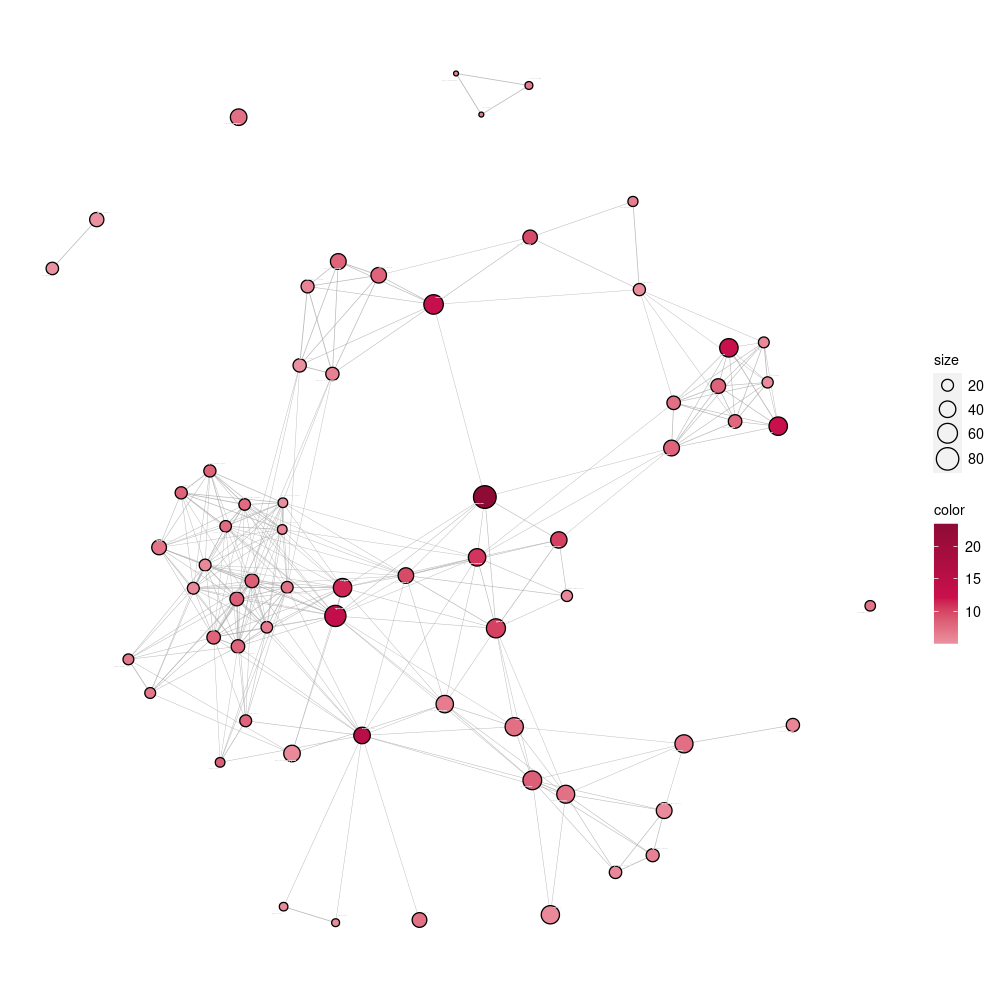

In [79]:
## BP
# go <- go_all[go_all$ONTOLOGY == 'BP']
ego <- filter(go_all,ONTOLOGY == 'BP')# Description %in% EC$Term) 
edox <- pairwise_termsim(ego)
edox <- mutate(edox, log10.p.adjust = -log10(as.numeric(p.adjust)))
edox <- filter(edox, log10.p.adjust >= 5)
dim(as.data.frame(edox))

file_name = paste(PAPER_DATA, 'Tab_S3_bp.csv', sep = .Platform$file.sep)
write.csv(as.data.frame(edox), file_name, row.names=FALSE)
dim(edox)


options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 100) 
pp <- emapplot(edox, 
                showCategory = 100, 
                color = "log10.p.adjust",
                layout = "fr",
                min_edge = 0.25,
                cex_label_category = 0, 
                colorEdge = FALSE,
                pie="Count",
                legend_n = 4,
                cex_line = 0.1) + 
                scale_size_continuous(range = c(1, 7) ) + #c(0.1, 3)) +
                scale_fill_gradient2( ## RED
                        high= "#8e0b36", #"#e41258",#"#d20638",#"#eb073f", #"#a8042c", #"#d20638",#"#eb073f",#"#eb073f",#"#e10b47",#"#e10b47",
                        mid = "#cb104e",#"#fff7e0", #'#ffd966',#"#ffecb2",#"#ffecb2",#"#ffd966",#
                        low = '#f4cfdb',#'blue',#"#fecedb",
                        midpoint = 12,
                        space = "rgb",
                        na.value = "grey50", 
                        guide = "colourbar")
     

pp

# ggsave(pp, file = "Plots/map_bp.pdf", 
#        width = 8,
#   height = 8)


[1] 66 11

Scale for size is already present.
Adding another scale for size, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


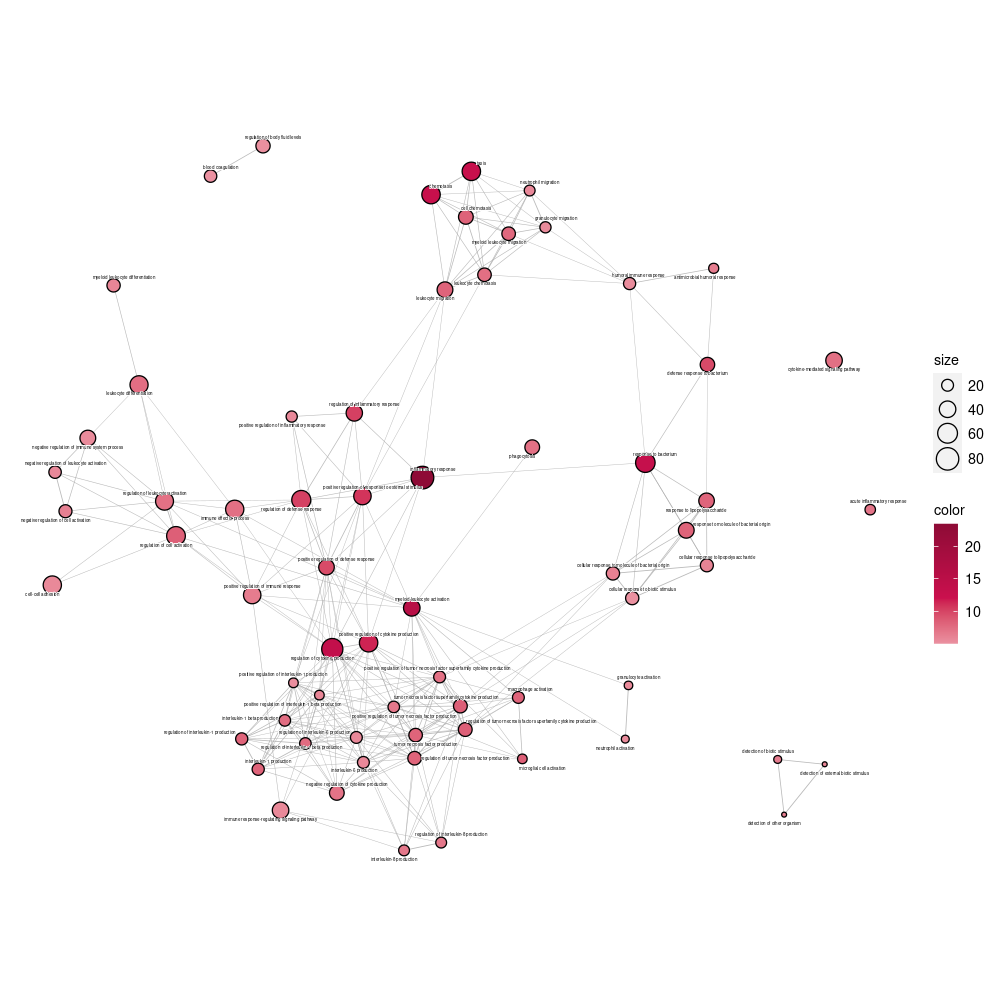

In [80]:
## BP
# go <- go_all[go_all$ONTOLOGY == 'BP']
ego <- filter(go_all,ONTOLOGY == 'BP')# Description %in% EC$Term) 
edox <- pairwise_termsim(ego)
edox <- mutate(edox, log10.p.adjust = -log10(as.numeric(p.adjust)))
edox <- filter(edox, log10.p.adjust >= 5)
dim(as.data.frame(edox))

options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 100) 
pp <- emapplot(edox, 
            showCategory = 100, #dim(edox)[1] ,
            color = "log10.p.adjust",
            layout = "fr",#"fr",#'nicely',#'fr',#'graphopt', #'fr',#'graphopt', #'nicely',#'fr',#'graphopt',#"star", #"gem",#"lgl",
            min_edge = 0.25,#0.2, #0.25,#0.3,
            cex_label_category = 0.2, #0.2, #0.2,# 0.4,
            colorEdge = FALSE,
            pie="Count",
            legend_n = 4,
            cex_line = 0.1) + 
            scale_size_continuous(range = c(1, 7) ) + #c(0.1, 3)) +
            scale_fill_gradient2( ## RED
                    high= "#8e0b36", #"#e41258",#"#d20638",#"#eb073f", #"#a8042c", #"#d20638",#"#eb073f",#"#eb073f",#"#e10b47",#"#e10b47",
                    mid = "#cb104e",#"#fff7e0", #'#ffd966',#"#ffecb2",#"#ffecb2",#"#ffd966",#
                    low = '#f4cfdb',#'blue',#"#fecedb",
                    midpoint = 12,
                    space = "rgb",
                    na.value = "grey50", 
                    guide = "colourbar")
     

pp

ggsave(pp, file = "Figures/Fig2_bp.pdf", 
       width = 8,
  height = 8)

> ## CC

In [81]:
go <- go_all[go_all$ONTOLOGY == 'CC']


[1] 36 11

Scale for size is already present.
Adding another scale for size, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


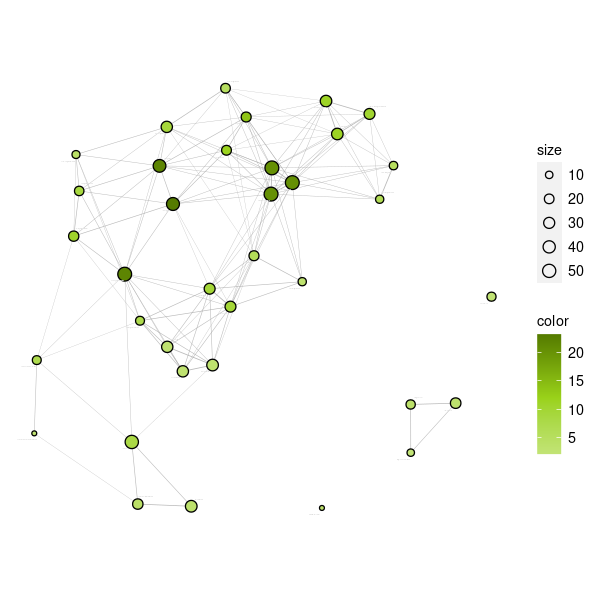

In [82]:
## CC
ego <- filter(go_all, ONTOLOGY == 'CC')
edox <- pairwise_termsim(ego)
edox <- mutate(edox, log10.p.adjust = -log10(as.numeric(p.adjust)))

file_name = paste(PAPER_DATA, 'Tab_S3_cc.csv', sep = .Platform$file.sep)
write.csv(as.data.frame(edox), file_name, row.names=FALSE)
dim(edox)

options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 100) 
pp <- emapplot(edox, 
  showCategory = 100, #dim(edox)[1] ,
  color = "log10.p.adjust",
  layout = 'fr',#'fr',#'graphopt', #'fr',#'graphopt', #'nicely',#'fr',#'graphopt',#"star", #"gem",#"lgl",
   min_edge = 0.1,#0.2, #0.25,#0.3,
  cex_label_category = 0, # 0.3, #0.3,
    colorEdge = FALSE,
  pie="Count",
  legend_n = 4,
  cex_line = 0.1) + 
 scale_size_continuous(range = c(1, 4)) +
 scale_fill_gradient2( 
                        ## GREEN
                         low = "#c7e67f",# "#ddf0b2",#'#c7e67f',
                        mid = "#9ad219",
                         high = "#557b00",#"#72a400",#"#72a400",
                  midpoint =12 ,
                      space = "rgb",
                        na.value = "grey50", 
                      guide = "colourbar")
     

pp

# ggsave(pp, file = "Supplementary/Fig2_cc.pdf", 
#        width = 4,
#   height = 4)


[1] 36 11

Scale for size is already present.
Adding another scale for size, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


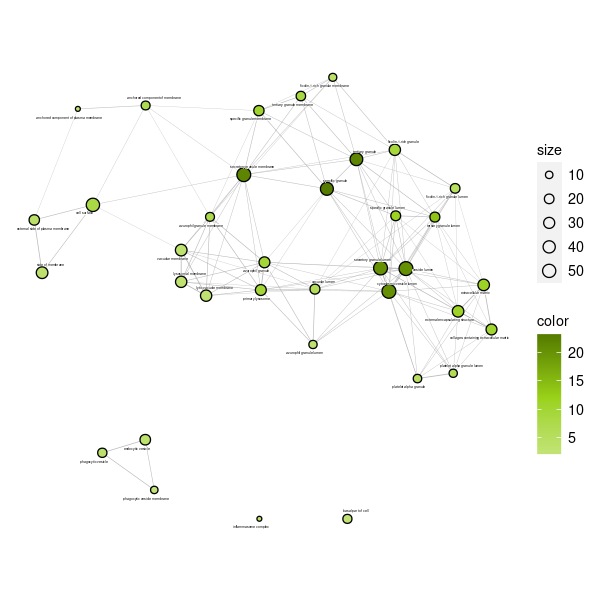

In [83]:
## CC
ego <- filter(go_all, ONTOLOGY == 'CC')
edox <- pairwise_termsim(ego)
edox <- mutate(edox, log10.p.adjust = -log10(as.numeric(p.adjust)))
dim(edox)
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 100) 
pp <- emapplot(edox, 
showCategory = 100, #dim(edox)[1] ,
color = "log10.p.adjust",
layout = 'fr',#'fr',#'graphopt', #'fr',#'graphopt', #'nicely',#'fr',#'graphopt',#"star", #"gem",#"lgl",
min_edge = 0.1,#0.2, #0.25,#0.3,
cex_label_category = 0.15, # 0.3, #0.3,
colorEdge = FALSE,
pie="Count",
legend_n = 4,
cex_line = 0.1) + 
scale_size_continuous(range = c(1, 4)) +
scale_fill_gradient2( 
                    ## GREEN
                    low = "#c7e67f",# "#ddf0b2",#'#c7e67f',
                    mid = "#9ad219",
                    high = "#557b00",#"#72a400",#"#72a400",
                    midpoint =12 ,
                    space = "rgb",
                    na.value = "grey50", 
                    guide = "colourbar")
     

pp

ggsave(pp, file = "Figures/Fig2_cc.pdf", 
       width = 4,
  height = 4)


> ## MF

[1] 29 11

Scale for size is already present.
Adding another scale for size, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


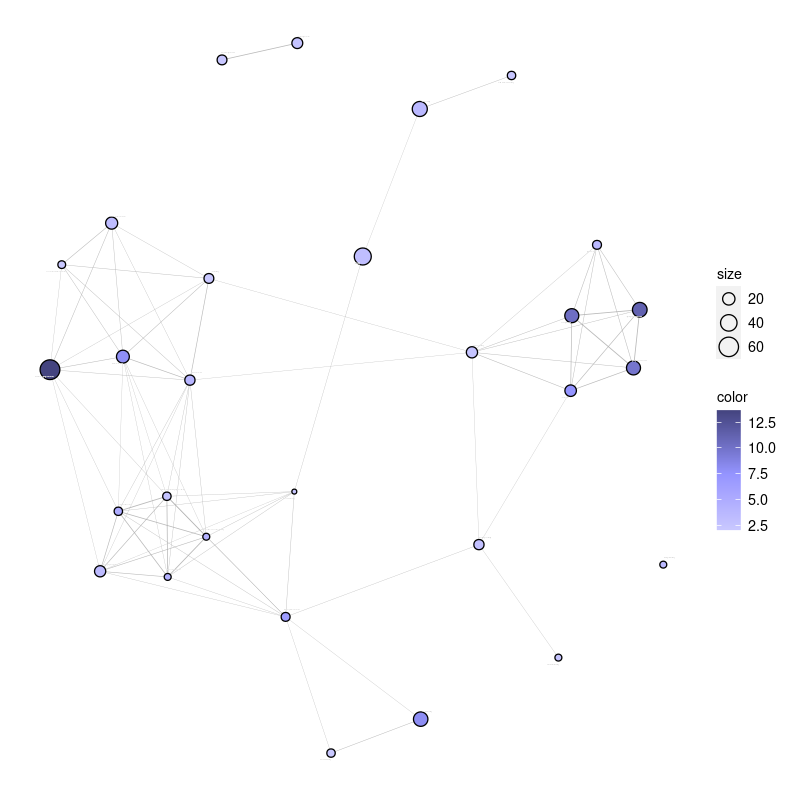

In [84]:
## MF
go <- go_all[go_all$ONTOLOGY == 'MF']
# go
ego <- filter(go_all, ONTOLOGY == 'MF')#filter(go_all, Description %in% EC$Term) #[EC$count >= 20,]#filter(ego, ONTOLOGY == 'BP')
edox <- pairwise_termsim(ego)
edox <- mutate(edox, log10.p.adjust = -log10(as.numeric(p.adjust)))
dim(edox)

file_name = paste(PAPER_DATA, 'Tab_S3_mf.csv', sep = .Platform$file.sep)
write.csv(as.data.frame(edox), file_name, row.names=FALSE)

options(repr.plot.width = 8, repr.plot.height = 8, repr.plot.res = 100) 
pp <- emapplot(edox, 
showCategory = 100, #dim(edox)[1] ,
color = "log10.p.adjust",
layout = 'fr',#'fr',#'graphopt', #'fr',#'graphopt', #'nicely',#'fr',#'graphopt',#"star", #"gem",#"lgl",
min_edge = 0.1, #0.1,#0.2, #0.25,#0.3,
cex_label_category = 0, # 0.3,
colorEdge = FALSE,
pie="Count",
legend_n = 4,
cex_line = 0.1) + 
scale_size_continuous(range = c(1, 6)) +
scale_fill_gradient2( 
                    ## BLUE
                    high = "#44447f",# "#525299",
                    mid = "#9494ff",
                    low = "#cfcfff",#"#b8b8ff",
                    midpoint = 7.5,
                    space = "rgb",
                    na.value = "grey50", 
                    guide = "colourbar")


pp



[1] 29 11

Scale for size is already present.
Adding another scale for size, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


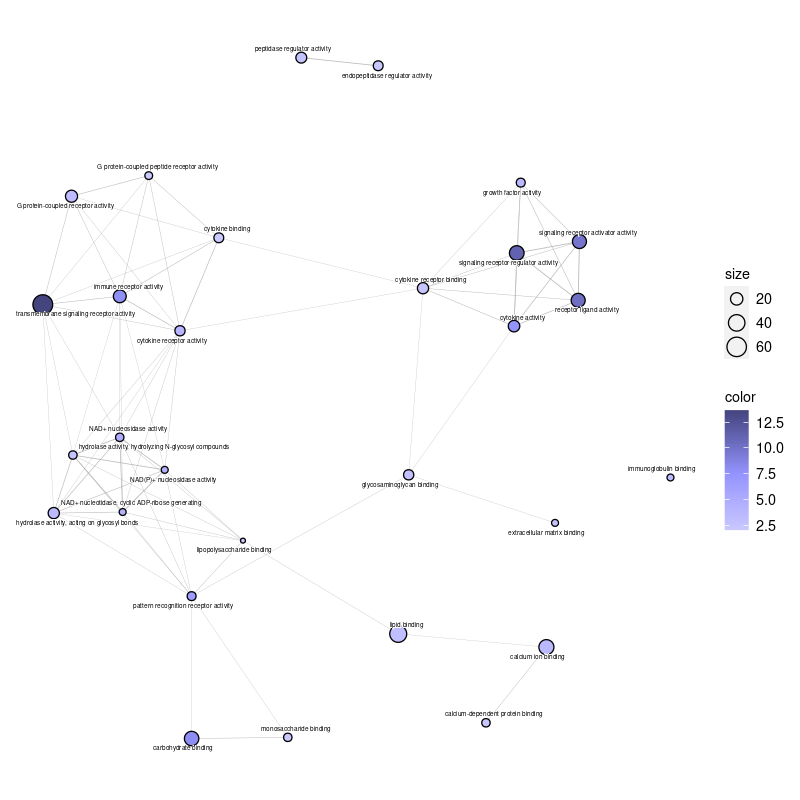

In [85]:
## MF
go <- go_all[go_all$ONTOLOGY == 'MF']
ego <- filter(go_all, ONTOLOGY == 'MF')#filter(go_all, Description %in% EC$Term) #[EC$count >= 20,]#filter(ego, ONTOLOGY == 'BP')
edox <- pairwise_termsim(ego)
edox <- mutate(edox, log10.p.adjust = -log10(as.numeric(p.adjust)))
dim(edox)

options(repr.plot.width = 8, repr.plot.height = 8, repr.plot.res = 100) 
pp <- emapplot(edox, 
                showCategory = 100, #dim(edox)[1] ,
                color = "log10.p.adjust",
                layout = 'fr',#'fr',#'graphopt', #'fr',#'graphopt', #'nicely',#'fr',#'graphopt',#"star", #"gem",#"lgl",
                min_edge = 0.1, #0.1,#0.2, #0.25,#0.3,
                cex_label_category = 0.3, # 0.3,
                colorEdge = FALSE,
                pie="Count",
                legend_n = 4,
                cex_line = 0.1) + 
                scale_size_continuous(range = c(1, 6)) +
                scale_fill_gradient2( 
                    ## BLUE
                    high = "#44447f",# "#525299",
                    mid = "#9494ff",
                    low = "#cfcfff",#"#b8b8ff",
                    midpoint = 7.5,
                    space = "rgb",
                    na.value = "grey50", 
                    guide = "colourbar")
     

pp

ggsave(pp, file = "Figures/Fig2_mf.pdf", 
       width = 5,
  height = 5)
